In [1]:
import numpy as np;
import matplotlib.pyplot as plt;
import scipy;
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import pandas;
import os;
import tensorflow as tf
from sklearn.externals import joblib
%matplotlib inline

In [2]:
print (os.getcwd())
images = os.listdir("Face/vid");

#This below code dynamically calculates the size of total data set.
train_size = len(images)+len(os.listdir("Face/vidFalse"))
#Face/vid contains true values and #Face/vidFalse contains false values.


count = 0
pixel = 100; #change the pixel size if the data set changes

#Depending on the size, X(Features) and Y(Labels) get initialized to zero.
train_data_X = np.zeros((train_size,pixel,pixel),dtype=float)
train_data_Y = np.zeros((train_size,1),dtype=float)

#It loads the true values and puts it in the train_data_X and sets train_data_y=1 ;
for i in images:
    img = np.array(plt.imread('Face/vid/'+i),dtype=float);
    train_data_X[count]=img*((img.max()-img.min())/img.max());#normalizes the data
    train_data_Y[count]=1;
    count = count+1
    
images = os.listdir("Face/vidFalse");

#It loads the false values and puts it in the train_data_X and sets train_data_y=0;
for i in images:
    img = np.array(plt.imread('Face/vidFalse/'+i),dtype=float);
    train_data_X[count]=img/(img.max());
    train_data_Y[count]=0;
    count = count+1
    
print (train_data_X.shape)
print (train_data_Y.shape)


/notebooks/project/datasci
(563, 100, 100)
(563, 1)


In [3]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_data_X,train_data_Y)

(563, 100, 100)


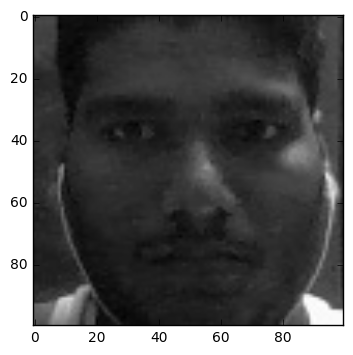

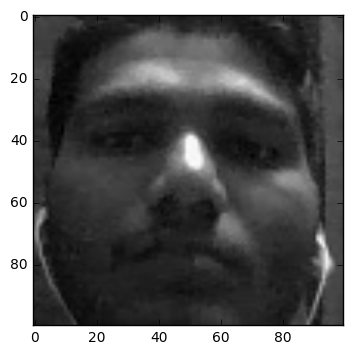

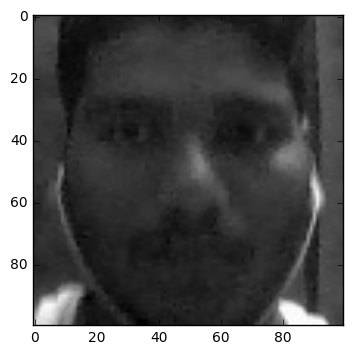

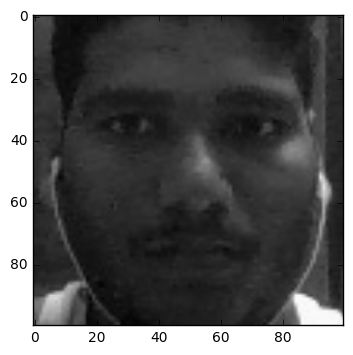

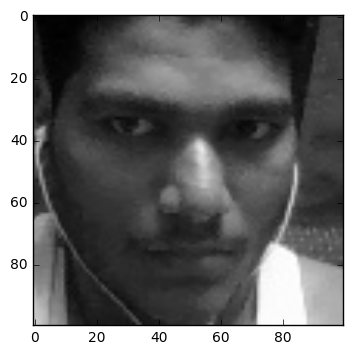

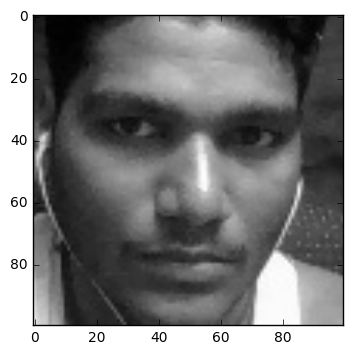

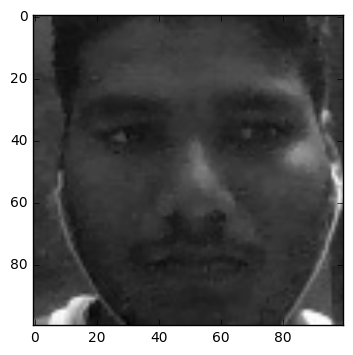

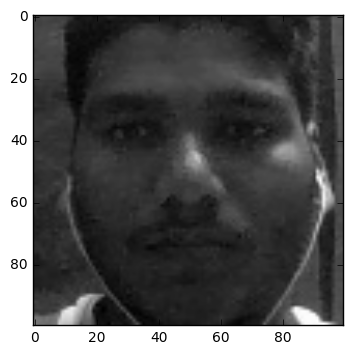

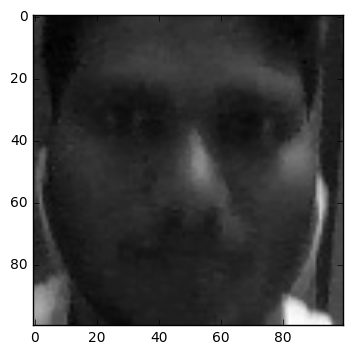

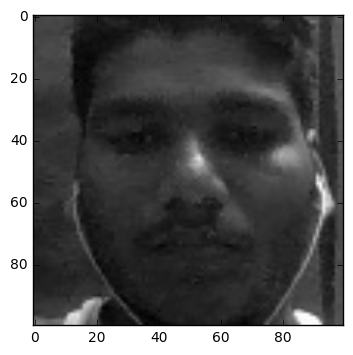

In [4]:
print (train_dataset.shape)
for i in xrange(0,len(train_dataset[:10])):
    plt.imshow(train_dataset[i],cmap='gray');
    plt.show();

In [13]:
image_size = 100
train_size = 500;
X_train = train_dataset[0:train_size].reshape(train_size,(image_size*image_size)).astype(np.float32);
y_train = train_labels[0:train_size].astype(np.float32)
X_test = train_dataset[train_size:].reshape(train_dataset[train_size:].shape[0],(image_size*image_size)).astype(np.float32);
y_test = train_labels[train_size:].astype(np.float32)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(500, 10000)
(500, 1)
(63, 10000)
(63, 1)


In [14]:
image_size = 100
num_labels = 1
num_steps = 100
batch_size = 10
alpha = 0.001;

In [15]:

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
def initNN():
    Weight = tf.Variable(tf.truncated_normal([5,5,1,16]))
    Weight1 = tf.Variable(tf.truncated_normal([4,4,16,32]))
    Weight2 = tf.Variable(tf.truncated_normal([4,4,32,48]))
    Weight3 = tf.Variable(tf.truncated_normal([13*13*48,1024]))
    Weight4 = tf.Variable(tf.truncated_normal([1024,num_labels]))
    bias = tf.Variable(tf.zeros([16]))
    bias1 = tf.Variable(tf.zeros([32]))
    bias2 = tf.Variable(tf.zeros([48]))
    bias3 = tf.Variable(tf.zeros([1024]))
    bias4 = tf.Variable(tf.zeros([num_labels]))
    return [Weight,bias,Weight1,bias1,Weight2,bias2,Weight3,bias3,Weight4,bias4]

def forwardCNN(X,W):
    X = tf.reshape(X,[-1,image_size,image_size,1])
    #1st Conv layer with max_pool
    H1 = conv2d(X,W[0])+W[1];
    H1 = tf.nn.relu(H1);
    H2 = max_pool_2x2(H1);
    
    #2nd Conv layer with max_pool
    H2 = conv2d(H2,W[2])+W[3];
    H2 = tf.nn.relu(H2);
    H3 = max_pool_2x2(H2);
    
    #3rd Conv layer with max_pool
    H3 = conv2d(H3,W[4])+W[5];
    H3 = tf.nn.relu(H3);
    H4 = max_pool_2x2(H3);
    
    #fully connected layer
    H4 = tf.reshape(H4, [-1, 13*13*48])
    H4 = tf.matmul(H4,W[6])+W[7];
    H4 = tf.nn.relu(H4);
    
    #output layer
    H4 = tf.matmul(H4,W[8])+W[9];
    return H4

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32,[None,image_size*image_size])
    y = tf.placeholder(tf.float32,[None,num_labels])
    W = initNN()
    H2 = forwardCNN(X,W)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(H2,y))
    optimizer = tf.train.AdamOptimizer(alpha).minimize(loss)
    train_prediction = (H2)
    valid_prediction = (forwardCNN(X_test,W))
    test = tf.nn.softmax(H2)

In [17]:
def accuracy1(predictions, labels):
    eq = (np.argmax(predictions, 1) == np.argmax(labels, 1))
    return ((100.0 * np.sum(eq))/eq.size)
def accuracy(predictions, labels):
    eq = (predictions == labels)
    print(predictions.shape,labels.shape)
    return ((100.0 * np.sum(eq))/eq.size)
Result = [];
sess = {};
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    offset=0
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        feed_dict = {X : batch_data, y : batch_labels}
        _, l, predictions,W = session.run([optimizer, loss, train_prediction,W],feed_dict=feed_dict)
        if (step % 20 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("mini batch accuracy: ", accuracy(predictions, batch_labels))            
            #print("Validation accuracy: ", accuracy(valid_prediction.eval(), y_valid))
    joblib.dump(W, 'FaceModels/Version1/vig_face.pkl')
    print("done")

Initialized
Minibatch loss at step 0: 0.000000
((10, 1), (10, 1))
('mini batch accuracy: ', 0.0)


TypeError: Fetch argument array([[[[ -3.98148358e-01,  -2.59894401e-01,   4.32232678e-01,
           -1.00826994e-01,  -7.57001042e-01,   3.87226820e-01,
            3.38462234e-01,  -7.75272489e-01,  -3.18637933e-03,
           -1.08687437e+00,   9.02311802e-02,  -4.43911105e-01,
            9.01378453e-01,   8.73371482e-01,   5.96659124e-01,
           -5.33383489e-01]],

        [[ -7.06458747e-01,   1.65169612e-01,  -5.65686703e-01,
           -1.48601794e+00,  -2.90384710e-01,  -2.71683812e-01,
            1.47392011e+00,   9.25482154e-01,   1.04518735e+00,
           -9.19645488e-01,   1.42729819e-01,  -1.46096158e+00,
            7.72421420e-01,   9.32894230e-01,   5.14470160e-01,
            2.89840966e-01]],

        [[ -1.39703542e-01,   1.12644160e+00,  -1.22977400e+00,
            7.68287778e-01,  -3.53581637e-01,   1.39221942e+00,
           -2.03425914e-01,   8.49069059e-01,   1.72907567e+00,
           -2.95885086e-01,   6.74387753e-01,   1.07497558e-01,
            5.00769496e-01,   1.71914101e-01,  -6.09992862e-01,
            1.87047076e+00]],

        [[  6.63485527e-01,   1.41991103e+00,  -5.21310456e-02,
            9.21624780e-01,  -3.99453878e-01,  -3.85697097e-01,
            9.86839905e-02,   4.53211963e-01,   8.36891830e-01,
            1.99622762e+00,  -3.34699571e-01,  -8.58977139e-01,
           -8.04033399e-01,  -5.73355407e-02,  -1.11522591e+00,
            7.65257359e-01]],

        [[  1.05869853e+00,   1.32521188e+00,   6.72310144e-02,
           -1.33827412e+00,  -7.22363710e-01,   1.16137218e+00,
            6.26458704e-01,   5.83325982e-01,  -7.54470587e-01,
            7.60860801e-01,  -3.23742419e-01,  -4.58639026e-01,
           -5.14594972e-01,   1.13900781e+00,   6.51610017e-01,
            9.87229288e-01]]],


       [[[ -5.82285464e-01,   1.30063578e-01,   6.35582805e-01,
           -4.40567911e-01,   2.16692746e-01,   1.10967278e+00,
           -3.18374604e-01,  -8.72770383e-04,   3.69113058e-01,
           -1.31268060e+00,  -1.33738041e+00,  -1.56749308e-01,
            2.80367076e-01,   3.91822815e-01,  -1.72303402e+00,
           -2.33180001e-01]],

        [[ -4.12444293e-01,  -4.79596347e-01,   4.28461023e-02,
            3.69092338e-02,  -5.43412089e-01,  -8.94321620e-01,
            1.40463436e+00,  -1.09153426e+00,   1.59739625e+00,
            4.03162122e-01,  -1.23026714e-01,   3.00012738e-01,
           -1.08336580e+00,   9.21325386e-01,   1.14817917e+00,
            7.66601741e-01]],

        [[  1.19363403e+00,   1.48701453e+00,  -8.85708272e-01,
            6.64777875e-01,   1.26738548e+00,  -1.03509653e+00,
           -2.89023191e-01,   1.10904503e+00,   2.21385732e-01,
           -1.94991827e+00,   1.60349548e+00,  -7.08365962e-02,
           -4.90093559e-01,  -2.12411389e-01,  -2.91436493e-01,
           -6.14740133e-01]],

        [[  1.02006495e+00,  -4.23755139e-01,  -3.90879124e-01,
            6.18732572e-01,  -1.26084650e+00,  -1.25300765e+00,
           -1.59751844e+00,  -3.52073878e-01,   1.22069359e+00,
           -3.68581325e-01,   1.97502661e+00,  -5.96005797e-01,
            9.07303333e-01,  -3.65520060e-01,  -6.89884245e-01,
            6.40537918e-01]],

        [[ -9.14747491e-02,  -3.84579957e-01,  -3.98652226e-01,
           -6.83173418e-01,  -1.93540975e-02,   5.77473640e-01,
           -2.55024254e-01,  -1.41144431e+00,   9.61571813e-01,
            1.49372622e-01,  -5.47285438e-01,  -1.23906541e+00,
            4.85193640e-01,  -3.56108427e-01,   6.58785924e-03,
            1.72565365e+00]]],


       [[[ -3.57712179e-01,   1.89351916e+00,  -5.72722018e-01,
           -8.41778159e-01,   1.96183753e+00,   5.32628536e-01,
            5.44580221e-01,  -5.55326760e-01,  -2.18468279e-01,
            8.26036751e-01,   3.80010068e-01,  -4.53796715e-01,
           -1.19301701e+00,  -1.06137335e+00,  -9.89419699e-01,
            2.18957305e-01]],

        [[ -1.04414344e-01,  -1.08774388e+00,  -8.22491467e-01,
           -7.93025911e-01,  -5.09825468e-01,  -9.32178676e-01,
           -1.11029041e+00,  -6.13529682e-01,  -9.91086602e-01,
           -1.32590428e-01,  -3.81330878e-01,   1.80914986e+00,
            7.60938108e-01,  -4.77725476e-01,   6.19492233e-01,
           -1.43085802e+00]],

        [[  7.97511995e-01,   4.81758475e-01,   6.74310088e-01,
           -1.28818089e-02,  -1.22516823e+00,  -3.89785349e-01,
           -4.07458514e-01,  -1.50006726e-01,  -1.52732074e-01,
            3.25295806e-01,  -1.87405622e+00,   3.62190425e-01,
           -1.38572425e-01,   1.23951185e+00,  -7.80680716e-01,
            1.84820616e+00]],

        [[ -9.27522242e-01,   2.98485160e-01,  -2.71468371e-01,
            5.21411896e-01,   9.75736856e-01,  -5.71774483e-01,
           -2.00521499e-01,  -2.71470666e-01,   1.26876092e+00,
           -3.35711211e-01,  -7.32933581e-01,  -7.55666375e-01,
           -4.68718022e-01,   1.05047393e+00,   6.69491649e-01,
           -1.29703162e-02]],

        [[  3.54772985e-01,  -2.96143413e-01,  -1.60924482e+00,
           -4.58568111e-02,  -1.15824139e+00,  -7.91968927e-02,
           -1.82316029e+00,   6.14016354e-01,   7.80274123e-02,
           -1.08341849e+00,   5.23971617e-01,  -1.58091974e+00,
            7.58282900e-01,  -1.63982496e-01,   6.28795624e-01,
           -1.11238897e+00]]],


       [[[  3.14717084e-01,  -4.99395788e-01,   1.87749195e+00,
           -1.57507789e+00,   1.43497300e+00,   8.02777290e-01,
            2.88207710e-01,   1.07550061e+00,  -5.36534548e-01,
           -7.81549215e-01,  -1.61751187e+00,  -8.84277701e-01,
            1.03289545e+00,   3.33704740e-01,  -4.74135727e-01,
            9.90189970e-01]],

        [[  3.38720202e-01,   1.94011629e+00,   3.85978036e-02,
            2.10151792e-01,  -6.41216576e-01,   7.69583106e-01,
            5.65744340e-01,   5.46009302e-01,   7.39790946e-02,
           -1.48308825e+00,  -2.14506000e-01,   1.90250620e-01,
            2.49687731e-01,  -7.92948842e-01,   1.54679883e+00,
            1.83709753e+00]],

        [[ -3.69116813e-01,   9.84247267e-01,   4.99829911e-02,
            1.92888081e-01,  -4.04146686e-02,   1.56726837e+00,
            5.05381763e-01,   6.67821243e-02,  -1.13171840e+00,
            3.58919442e-01,  -9.41455483e-01,  -5.13358951e-01,
            1.61305022e+00,  -1.48837686e-01,   3.28896731e-01,
            5.11170983e-01]],

        [[  4.70904052e-01,  -1.83230960e+00,   8.52945983e-01,
            2.64805034e-02,   3.69810462e-01,  -3.51383477e-01,
            2.01360583e-01,   1.26011169e+00,   2.83678472e-01,
            2.00335547e-01,   7.51030922e-01,   1.08893335e+00,
           -8.75656068e-01,   6.13075495e-01,   1.37664163e+00,
           -1.56848991e+00]],

        [[  9.15181518e-01,   8.52175951e-02,  -9.16696191e-01,
           -1.36156952e+00,  -1.78239167e-01,   7.64587894e-02,
            4.91889924e-01,   7.42826760e-01,  -1.53052580e+00,
            2.38670900e-01,   5.77126145e-01,  -9.14134979e-01,
           -3.67305309e-01,   1.16529620e+00,  -1.01725972e+00,
           -1.42576396e+00]]],


       [[[ -2.03339145e-01,  -8.03823292e-01,  -1.51239562e+00,
           -5.68830132e-01,  -7.05869019e-01,  -2.20386550e-01,
            8.10890853e-01,   7.37259626e-01,   3.73104155e-01,
            1.69745773e-01,   2.64400721e-01,   3.82351160e-01,
            7.64670730e-01,   5.64508140e-01,   1.10035747e-01,
           -4.21970904e-01]],

        [[  3.93196255e-01,   1.41634154e+00,  -2.38679066e-01,
           -9.61554706e-01,  -8.57543707e-01,   9.24628615e-01,
            1.21021140e+00,  -1.01823688e+00,   7.63850510e-01,
            8.41557831e-02,  -5.37139833e-01,  -4.12916929e-01,
            6.43510967e-02,   4.53519216e-03,   8.82994354e-01,
           -6.21900678e-01]],

        [[ -6.74909294e-01,   5.31581938e-01,   8.62932861e-01,
            7.29095995e-01,  -1.49169183e+00,   9.55704570e-01,
           -6.16147101e-01,   2.01376870e-01,   1.18531525e+00,
            8.27115893e-01,  -6.53502226e-01,   7.13194489e-01,
            2.13265210e-01,  -1.46438122e-01,  -7.73222923e-01,
           -2.32971683e-02]],

        [[  1.42705393e+00,  -6.94068670e-01,  -1.17405746e-02,
           -3.11346233e-01,   4.30012584e-01,   6.91138268e-01,
           -7.61632174e-02,  -1.26615798e+00,  -6.25869751e-01,
           -3.08059573e-01,   8.36563885e-01,  -7.34199464e-01,
            6.44278407e-01,  -1.15026653e+00,   1.64195269e-01,
           -1.01950681e+00]],

        [[  1.28861684e-02,  -5.83447665e-02,  -1.22530937e+00,
           -3.70281816e-01,  -1.64418411e+00,   1.47003615e+00,
            1.00318980e+00,  -3.74620408e-01,  -5.65926611e-01,
            5.95413446e-01,   1.22966729e-01,   1.67348361e+00,
           -7.57475555e-01,   7.55119026e-01,  -1.03097951e+00,
            7.99305499e-01]]]], dtype=float32) has invalid type <type 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)